# Post-processing unattended TG ApRES data
The aim of this notebook is to convert all the dat files from each continuous (attended) ApRES dataset from Thwaites into a zarr store on the google bucket or locally, while also, optionally, computing the profiles (fft) and stacking (.mean(dim='chirp_num'). 


The following steps are performed for each dataset:

- load all the dat files using xapres.load_all
- save that to a zarr directory locally
- rechunk that zarr using rechunker to `{'chirp_time': -1, 'chirp_num': 10}` and save on the google bucket at `/SITE_NAME/zarr/rechunked.zarr`
- load the result lazily then add the profiles, add the stacked profiles and the stacked chirps,
- save the result as `/SITE_NAME/zarr/full.zarr`

This has been run for the following three sites where I found that the dat files had been collected together in a file called `dats`:

- ApRES_LTG
- ApRES_Lake1
- ApRES_Lake2

## Summary
This NB produced the following three zarr stores:
- gs://ldeo-glaciology/apres/thwaites/continuous/ApRES_LTG/zarr/full.zarr
- gs://ldeo-glaciology/apres/thwaites/continuous/ApRES_Lake1/zarr/full.zarr
- gs://ldeo-glaciology/apres/thwaites/continuous/ApRES_Lake2/zarr/full.zarr

They can be loaded with, for example:
```
import xarray as xr
f = 'gs://ldeo-glaciology/apres/thwaites/continuous/ApRES_LTG/zarr/full.zarr'
ds = xr.open_dataset(f, engine = 'zarr', chunks = {})
```

In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:45671")
client

<Client: 'tcp://127.0.0.1:45671' processes=10 threads=10, memory=74.18 GiB>

In [1]:
#from rechunker import rechunk
from dask.diagnostics import ProgressBar
from dask.distributed import performance_report
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2 
import sys
#sys.path.append("/home/jovyan/xapres/")
sys.path.append("/Users/jkingslake/Documents/science/ApRES/xapres")
import matplotlib.pyplot as plt
import xapres as xa
import numpy as np
import xarray as xr
import zarr
import os
import json
import fsspec
import geopandas as gpd

## test that all dat files in SD1 folder are in the dat_files folders
for ApRES_LTG, ApRES_Lake1, and ApRES_Lake2, all the dat files have been collated into a folder called dat_files. 

We should check that they are all there. If so we can just use the folder SD1 instead of copying the files.

In fact, I ended up just using the old approach because it simplifies selected and sorting the dat files. 


In [2]:
sites = ["ApRES_LTG", "ApRES_Lake1", "ApRES_Lake2", "ApRES_Takahe1_204", "ApRES_Takahe2_203"]
tg_1 = xa.load.from_dats()
root = "/Users/jkingslake/Documents/data/thwaites_apres/original/continuous/"

for site in sites[0:3]:
    #sd1_path = os.path.join(root, site, "SD1")

    dats_in_sd1 = tg_1.list_files(directory=os.path.join(root, site, "SD1"))
    dats_in_dat_files_dir = tg_1.list_files(directory=os.path.join(root, site, "dat_files"))
    
    sorted_dats_in_sd1_names = [x.split("/")[-1] for x in sorted(dats_in_sd1)]
    sorted_dats_in_dat_files_dir_names = [x.split("/")[-1] for x in sorted(dats_in_dat_files_dir)]
    
    assert sorted_dats_in_sd1_names == sorted_dats_in_dat_files_dir_names
    print(f"All dat files in {site} SD1 folder are in the dat_files folder.")



All dat files in ApRES_LTG SD1 folder are in the dat_files folder.
All dat files in ApRES_Lake1 SD1 folder are in the dat_files folder.
All dat files in ApRES_Lake2 SD1 folder are in the dat_files folder.


In [12]:
for site in sites:
    dat_directory = os.path.join(root, site, "dat_files")
    filepaths = tg_1.list_files(directory=dat_directory)
    print(f"there are {len(filepaths)} files from {site}")
    one_dat = tg_1.load_all(directory = dat_directory, file_numbers_to_process=[7], computeProfiles = False, disable_progress_bar=True)
    print(f"total size of dataset without profiles computed = {one_dat.nbytes/1e9 * len(filepaths):.2f} GB")

there are 181 files from ApRES_LTG
total size of dataset without profiles computed = 11.64 GB
there are 185 files from ApRES_Lake1
total size of dataset without profiles computed = 11.90 GB
there are 60 files from ApRES_Lake2
total size of dataset without profiles computed = 26.90 GB
there are 29 files from ApRES_Takahe1_204
total size of dataset without profiles computed = 12.07 GB
there are 34 files from ApRES_Takahe2_203
total size of dataset without profiles computed = 14.16 GB


In [13]:
site = sites[2]
print(f"Working on {site}")
#root = f"gs://ldeo-glaciology/apres/thwaites/continuous/{site}"
dat_directory = os.path.join(root, site, "dat_files")
filepaths = tg_1.list_files(directory=dat_directory)
print(f"there are {len(filepaths)} files from {site}")
#(filepaths)

Working on ApRES_Lake2
there are 60 files from ApRES_Lake2


In [14]:
attenuator_settings = []
AFGain_settings = []

for filepath in sorted(filepaths)[3:]:
    print(f"Processing file {filepath}")
    try:
        ds = tg_1.load_all(directory = dat_directory, computeProfiles = False, file_names_to_process=[filepath])  
        attenuator_settings.append(ds.attenuator.values[0])
        AFGain_settings.append(ds.AFGain.values[0])                         
        print(f"{ds.attenuator.values}, {ds.AFGain.values}")
    except Exception as e:
        print(f"Error processing file {filepath}: {e}")
        continue
#ds = tg_1.load_all(directory = dat_directory, computeProfiles = False)#, file_numbers_to_process=list(range(0,5)))
#ds

Processing file /Users/jkingslake/Documents/data/thwaites_apres/original/continuous/ApRES_Lake2/dat_files/DATA2023-01-16-0619.DAT
[6.], [-14]
Processing file /Users/jkingslake/Documents/data/thwaites_apres/original/continuous/ApRES_Lake2/dat_files/DATA2023-01-23-0620.DAT
[6.], [-14]
Processing file /Users/jkingslake/Documents/data/thwaites_apres/original/continuous/ApRES_Lake2/dat_files/DATA2023-01-24-1807.DAT
[6.], [-14]
Processing file /Users/jkingslake/Documents/data/thwaites_apres/original/continuous/ApRES_Lake2/dat_files/DATA2023-01-31-1808.DAT
[6.], [-14]
Processing file /Users/jkingslake/Documents/data/thwaites_apres/original/continuous/ApRES_Lake2/dat_files/DATA2023-02-07-1809.DAT
[6.], [-14]
Processing file /Users/jkingslake/Documents/data/thwaites_apres/original/continuous/ApRES_Lake2/dat_files/DATA2023-02-14-1810.DAT
[6.], [-14]
Processing file /Users/jkingslake/Documents/data/thwaites_apres/original/continuous/ApRES_Lake2/dat_files/DATA2023-02-21-1810.DAT
[6.], [-14]
Proces

In [15]:
#first_index_of_final_AFGain = [i for i, x in enumerate(AFGain_settings) if x==AFGain_settings[-1]][0]
#first_index_of_final_attenuator = [i for i, x in enumerate(attenuator_settings) if x==attenuator_settings[-1]][0]
#assert first_index_of_final_attenuator==first_index_of_final_AFGain
#print(f"first index of final AFGain = {first_index_of_final_AFGain}, first index of final attenuator = {first_index_of_final_attenuator}")
#print(f"with will start with dat file number {first_index_of_final_AFGain }")
#start_dat_file_number = first_index_of_final_AFGain

The first few dat files at each site contain data collected using different attenuator settings or in a different location, or not regularly spaced with the otehr data, so we skip those, because they cant easily be concatenated with the rest of the data and they are likely just test shots taken on the day of installation. 

In [16]:
if site == 'ApRES_LTG': 
    start_dat_file_number = 4  # the first 4 use the same attenuator settings, but they are not regularly spaces in time with the other data
elif site == 'ApRES_Lake1':
    start_dat_file_number = 3  # the first 3 use different attenuator settings. THis is the first one which is regularly spaced in time with the other data
elif site == 'ApRES_Lake2':
    start_dat_file_number = 4  # This is the first one which is regularly spaced in time with the other data
elif site == 'ApRES_Takahe1_204':
    start_dat_file_number = 0
elif site == 'ApRES_Takahe2_203':
    start_dat_file_number = 3 # something is up with the first 3 files some seem to have no data and one is the wrong size. 
else:
    raise ValueError(f"Unknown site {site}")

dat_size = os.path.getsize(filepaths[start_dat_file_number+5])


f = sorted(filepaths)[start_dat_file_number:]

In [5]:
dat_size

104020279

In [6]:
# split list into block N big
N = int(17*104e6/dat_size)  # number of files to process in each block
file_lists = [f[i:i + N] for i in range(0, len(f), N)]
print(f'created {len(file_lists)} file lists from {len(f)} files')
print(f'list sizes: {[len(x) for x in file_lists]}')


created 2 file lists from 31 files
list sizes: [16, 15]


In [7]:
nc_locations = [f'ncs/{site}/part_{i}.nc' for i in range(len(file_lists))]
os.makedirs(f"ncs/{site}", exist_ok=True) 
nc_locations

['ncs/ApRES_Takahe2_203/part_0.nc', 'ncs/ApRES_Takahe2_203/part_1.nc']

In [8]:
def remove_constants_attr(ds):
    for c in ds.attrs['constants']:
        ds.attrs[c] = ds.attrs['constants'][c]
    del ds.attrs['constants']
    return ds

In [9]:
for i, file_list in enumerate(file_lists):
    print(f"Processing {len(file_list)} files")
    ds = tg_1.load_all(directory = dat_directory, 
                       computeProfiles = False,
                       file_names_to_process=file_list,
                       disable_progress_bar=False)
    
    ds["chirp_time"].attrs["units"] = "unscaled seconds"
    ds = remove_constants_attr(ds)
    
    ds.to_netcdf(nc_locations[i])

Processing 16 files


100%|██████████| 16/16 [00:03<00:00,  5.25it/s]


Processing 15 files


100%|██████████| 15/15 [00:03<00:00,  4.17it/s]


RuntimeError: NetCDF: HDF error

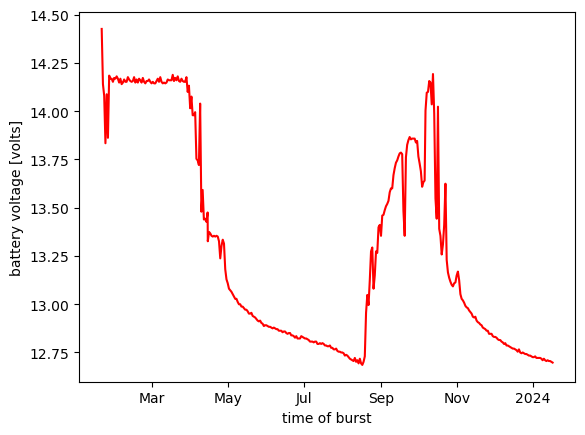

In [75]:
ds_r = xr.open_mfdataset(f"ncs/*{site}*.nc")
ds_r.battery_voltage.plot(color='red', label='ds_r')

In [4]:
import sys

sys.path.append("/Users/jkingslake/Documents/science/ApRES/xapres")
import xapres as xa
import numpy as np
import xarray as xr
import os

sites = ["ApRES_LTG", "ApRES_Lake1", "ApRES_Lake2", "ApRES_Takahe1_204", "ApRES_Takahe2_203"]

tg_1 = xa.load.from_dats()
root = "/Users/jkingslake/Documents/data/thwaites_apres/original/continuous/"

def remove_constants_attr(ds):
    for c in ds.attrs['constants']:
        ds.attrs[c] = ds.attrs['constants'][c]
    del ds.attrs['constants']
    return ds

for site in sites:
    dat_directory = os.path.join(root, site, "dat_files")
    filepaths = tg_1.list_files(directory=dat_directory)
    print(f"there are {len(filepaths)} files from {site}")
    one_dat = tg_1.load_all(directory = dat_directory, file_numbers_to_process=[7], computeProfiles = False, disable_progress_bar=True)
    print(f"total size of dataset without profiles computed = {one_dat.nbytes/1e9 * len(filepaths):.2f} GB")

    if site == 'ApRES_LTG': 
        start_dat_file_number = 4  # the first 4 use the same attenuator settings, but they are not regularly spaces in time with the other data
    elif site == 'ApRES_Lake1':
        start_dat_file_number = 3  # the first 3 use different attenuator settings. THis is the first one which is regularly spaced in time with the other data
    elif site == 'ApRES_Lake2':
        start_dat_file_number = 4  # This is the first one which is regularly spaced in time with the other data
    elif site == 'ApRES_Takahe1_204':
        start_dat_file_number = 0
    elif site == 'ApRES_Takahe2_203':
        start_dat_file_number = 3 # something is up with the first 3 files some seem to have no data and one is the wrong size. 
    else:
        raise ValueError(f"Unknown site {site}")

    dat_size = os.path.getsize(filepaths[start_dat_file_number+5])
    print(f"dat file size = {dat_size/1e6:.2f} MB")

    f = sorted(filepaths)[start_dat_file_number:]

    # split list into block N big
    N = int(17*104e6/dat_size)  # number of files to process in each block
    file_lists = [f[i:i + N] for i in range(0, len(f), N)]
    print(f'created {len(file_lists)} file lists from {len(f)} files')
    print(f'list sizes: {[len(x) for x in file_lists]}')


    nc_locations = [f'ncs/{site}/part_{i}.nc' for i in range(len(file_lists))]
    os.makedirs(f"ncs/{site}", exist_ok=True) 
    

    for i, file_list in enumerate(file_lists):
        print(f"Processing {len(file_list)} files")
        ds = tg_1.load_all(directory = dat_directory, 
                        computeProfiles = False,
                        file_names_to_process=file_list,
                        disable_progress_bar=False)
        
        ds["chirp_time"].attrs["units"] = "unscaled seconds"
        ds = remove_constants_attr(ds)
        
        ds.to_netcdf(nc_locations[i])

there are 181 files from ApRES_LTG
total size of dataset without profiles computed = 11.64 GB
dat file size = 8.00 MB
created 1 file lists from 177 files
list sizes: [177]
Processing 177 files


100%|██████████| 177/177 [00:05<00:00, 35.16it/s]


there are 185 files from ApRES_Lake1
total size of dataset without profiles computed = 11.90 GB
dat file size = 16.00 MB
created 2 file lists from 182 files
list sizes: [110, 72]
Processing 110 files


 42%|████▏     | 46/110 [00:01<00:02, 23.20it/s]


KeyboardInterrupt: 

In [9]:
nc_locations

['ncs/ApRES_Takahe2_203/part_0.nc', 'ncs/ApRES_Takahe2_203/part_1.nc']

In [ ]:
ds_r = xr.open_mfdataset(f'ncs/ApRES_Takahe2_203/*.nc')
ds_r

In [54]:
one_dat = tg_1.load_all(directory = dat_directory, file_numbers_to_process=[7], computeProfiles = False, disable_progress_bar=False)

100%|██████████| 1/1 [00:00<00:00,  4.71it/s]


In [133]:
ds1 = tg_1.load_all(directory = dat_directory, 
                       computeProfiles = False,
                       file_names_to_process=sorted(filepaths)[start_dat_file_number:N],
                       disable_progress_bar=False)

ds1["chirp_time"].attrs["units"] = "unscaled seconds"
ds1 = remove_constants_attr(ds1)
ds1.to_netcdf(f'ncs/{site}_1.nc')

100%|██████████| 15/15 [00:03<00:00,  4.82it/s]


In [134]:
ds2 = tg_1.load_all(directory = dat_directory, 
                       computeProfiles = False,
                       file_names_to_process=sorted(filepaths)[N:],
                       disable_progress_bar=False)
ds2["chirp_time"].attrs["units"] = "unscaled seconds"
ds2 = remove_constants_attr(ds2)
ds2.to_netcdf(f'ncs/{site}_2.nc')

100%|██████████| 16/16 [00:03<00:00,  4.34it/s]


In [81]:
raw_ds_location = f'zarrs/{site}'
ds.to_zarr(raw_ds_location)  


In [11]:
ds1_r = xr.open_dataset(f'ncs/{site}_1.nc', engine = 'netcdf4')
ds2_r = xr.open_dataset(f'ncs/{site}_2.nc', engine = 'netcdf4')

ds1_r

<xarray.Dataset> Size: 6GB
Dimensions:          (time: 187, chirp_num: 100, attenuator_setting_pair: 1,
                      chirp_time: 40001)
Coordinates:
  * time             (time) datetime64[ns] 1kB 2023-01-20T02:07:57 ... 2023-0...
  * chirp_time       (chirp_time) float64 320kB 0.0 2.5e-05 5e-05 ... 1.0 1.0
  * chirp_num        (chirp_num) int64 800B 0 1 2 3 4 5 6 ... 94 95 96 97 98 99
    filename         (time) <U23 17kB ...
    folder_name      (time) <U9 7kB ...
    burst_number     (time) int64 1kB ...
    AFGain           (attenuator_setting_pair) int64 8B ...
    attenuator       (attenuator_setting_pair) float64 8B ...
    orientation      (time) <U7 5kB ...
Dimensions without coordinates: attenuator_setting_pair
Data variables:
    chirp            (time, chirp_num, attenuator_setting_pair, chirp_time) float64 6GB ...
    latitude         (time) float64 1kB ...
    longitude        (time) float64 1kB ...
    battery_voltage  (time) float64 1kB ...
    temperature_1    (time) float64 1kB ...
    temperature_2    (time) float64 1kB ...
Attributes:
    processing:  Created on 2025-07-01 15:47:23.719439
    c:           300000000.0
    K:           200000000.0
    f_1:         200000000.0
    f_2:         400000000.0
    dt:          2.5e-05
    ep:          3.18
    B:           200000000.0
    f_c:         300000000.0

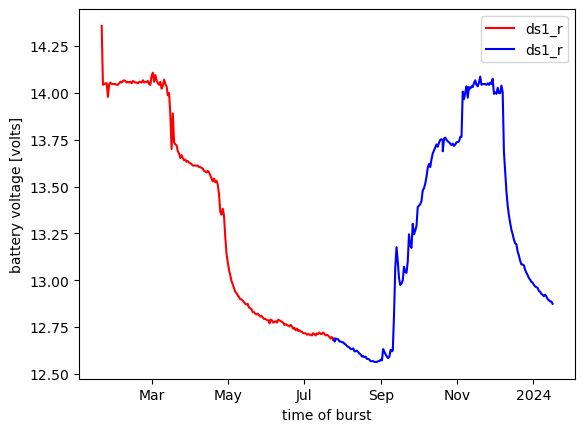

In [12]:
ds1_r.battery_voltage.plot(color='red', label='ds1_r')
ds2_r.battery_voltage.plot(color='blue', label='ds1_r')
plt.legend()


In [80]:
def load_zarr(f):
    return xr.open_dataset(f, engine = 'zarr', chunks = {})

## Load all and save to zarr
Load all the data from this site into local memory, without computing the profiles, then save it back to local sotrage as a zarr. 

Computing all the profiles is an expensive operation, so we would like to use a dask cluster. But to use the cluster, this needs to be a dask array. This is a way of solving that because the zarr that it creates can be loaded to get the data loaded lazily. 



In [12]:
raw_ds_location = f'zarrs/{site}'

if site == 'ApRES_Lake2':
    N = (len(filepaths)-start_dat_file_number)//2 + start_dat_file_number 
    ds = tg_1.load_all(directory = dat_directory, 
                       computeProfiles = False,
                       file_numbers_to_process=list(range(start_dat_file_number, N)))
    ds.to_zarr(raw_ds_location)  
    
    del ds
    ds = tg_1.load_all(directory = dat_directory, 
                       computeProfiles = False,
                       file_numbers_to_process=list(range(N, len(filepaths))))
    ds.to_zarr(raw_ds_location, append_dim='time')  
    
else:
    
    ds = tg_1.load_all(directory = dat_directory, 
                       computeProfiles = False,
                       file_numbers_to_process=list(range(start_dat_file_number,len(filepaths))))
    ds.to_zarr(raw_ds_location)
#print(ds.nbytes/1e9)

100%|██████████| 177/177 [08:51<00:00,  3.00s/it]


In [ ]:
def remove_constants_attr(ds):
    for c in ds.attrs['constants']:
        ds.attrs[c] = ds.attrs['constants'][c]
    del ds.attrs['constants']
    return ds
ds = remove_constants_attr(ds)
ds


KeyError: 'constants'

In [99]:
ds.to_netcdf(f'ncs/{site}.nc')

## Load from zarr
To get a lazily loaded dataset containing dask arrays, we load from 

In [91]:
xr.open_dataset(raw_ds_location, engine = 'zarr', chunks = True)


/var/folders/kl/3mt9f4qs1559xwy3mr60s7980000gp/T/ipykernel_39388/1937285066.py:1: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  xr.open_dataset(raw_ds_location, engine = 'zarr', chunks = True)
/var/folders/kl/3mt9f4qs1559xwy3mr60s7980000gp/T/ipykernel_39388/1937285066.py:1: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  xr.open_dataset(raw_ds_location, engine = 'zarr', chunks = True)
/var/folders/kl/3mt9f4qs1559xwy3mr60s7980000gp/T/ipykernel_39388/1937285066.py:1: UserWarning: The specified chunks separate the stored chunks along dimension "chirp_num" starting at index 1. This could degrade performance. Instead, consider rechunking after loading.
  xr.open_dataset(raw_ds_location, engine = 'zarr', chu

<xarray.Dataset> Size: 12GB
Dimensions:          (attenuator_setting_pair: 1, time: 365, chirp_num: 100,
                      chirp_time: 40001)
Coordinates:
    AFGain           (attenuator_setting_pair) int64 8B dask.array<chunksize=(1,), meta=np.ndarray>
    attenuator       (attenuator_setting_pair) float64 8B dask.array<chunksize=(1,), meta=np.ndarray>
    burst_number     (time) int64 3kB dask.array<chunksize=(1,), meta=np.ndarray>
  * chirp_num        (chirp_num) int64 800B 0 1 2 3 4 5 6 ... 94 95 96 97 98 99
  * chirp_time       (chirp_time) timedelta64[ns] 320kB 00:00:00 ... 00:00:01
    filename         (time) <U23 34kB dask.array<chunksize=(1,), meta=np.ndarray>
    folder_name      (time) <U9 13kB dask.array<chunksize=(1,), meta=np.ndarray>
    orientation      (time) <U7 10kB dask.array<chunksize=(1,), meta=np.ndarray>
  * time             (time) datetime64[ns] 3kB 2023-01-20T02:07:57 ... 2024-0...
Dimensions without coordinates: attenuator_setting_pair
Data variables:
    battery_voltage  (time) float64 3kB dask.array<chunksize=(1,), meta=np.ndarray>
    chirp            (time, chirp_num, attenuator_setting_pair, chirp_time) float64 12GB dask.array<chunksize=(1, 1, 1, 1), meta=np.ndarray>
    latitude         (time) float64 3kB dask.array<chunksize=(1,), meta=np.ndarray>
    longitude        (time) float64 3kB dask.array<chunksize=(1,), meta=np.ndarray>
    temperature_1    (time) float64 3kB dask.array<chunksize=(1,), meta=np.ndarray>
    temperature_2    (time) float64 3kB dask.array<chunksize=(1,), meta=np.ndarray>
Attributes:
    constants:   {'B': 200000000.0, 'K': 200000000.0, 'c': 300000000.0, 'dt':...
    processing:  Created on 2025-07-01 14:18:32.993668

In [82]:
r = load_zarr(raw_ds_location)

/var/folders/kl/3mt9f4qs1559xwy3mr60s7980000gp/T/ipykernel_39388/2203986148.py:2: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  return xr.open_dataset(f, engine = 'zarr', chunks = {})


In [83]:
r

<xarray.Dataset> Size: 12GB
Dimensions:          (attenuator_setting_pair: 1, time: 365, chirp_num: 100,
                      chirp_time: 40001)
Coordinates:
    AFGain           (attenuator_setting_pair) int64 8B dask.array<chunksize=(1,), meta=np.ndarray>
    attenuator       (attenuator_setting_pair) float64 8B dask.array<chunksize=(1,), meta=np.ndarray>
    burst_number     (time) int64 3kB dask.array<chunksize=(365,), meta=np.ndarray>
  * chirp_num        (chirp_num) int64 800B 0 1 2 3 4 5 6 ... 94 95 96 97 98 99
  * chirp_time       (chirp_time) timedelta64[ns] 320kB 00:00:00 ... 00:00:01
    filename         (time) <U23 34kB dask.array<chunksize=(365,), meta=np.ndarray>
    folder_name      (time) <U9 13kB dask.array<chunksize=(365,), meta=np.ndarray>
    orientation      (time) <U7 10kB dask.array<chunksize=(365,), meta=np.ndarray>
  * time             (time) datetime64[ns] 3kB 2023-01-20T02:07:57 ... 2024-0...
Dimensions without coordinates: attenuator_setting_pair
Data variables:
    battery_voltage  (time) float64 3kB dask.array<chunksize=(365,), meta=np.ndarray>
    chirp            (time, chirp_num, attenuator_setting_pair, chirp_time) float64 12GB dask.array<chunksize=(23, 7, 1, 5001), meta=np.ndarray>
    latitude         (time) float64 3kB dask.array<chunksize=(365,), meta=np.ndarray>
    longitude        (time) float64 3kB dask.array<chunksize=(365,), meta=np.ndarray>
    temperature_1    (time) float64 3kB dask.array<chunksize=(365,), meta=np.ndarray>
    temperature_2    (time) float64 3kB dask.array<chunksize=(365,), meta=np.ndarray>
Attributes:
    constants:   {'B': 200000000.0, 'K': 200000000.0, 'c': 300000000.0, 'dt':...
    processing:  Created on 2025-07-01 14:18:32.993668

The result is a dataset containing dask arrays. 


## Rechunk
A remaining issue is that the data is chunked in the `chirp_time` dimension. The fft step of computing the profiles requires the data to not be chunked in this dimension. 

We use rechunker to rechunk to the following chunks sizes: (23, 40001, 10, 1), following this guide: https://rechunker.readthedocs.io/en/latest/tutorial.html#Rechunk-a-Group

First we step up a temporary location to store data and the final target location. For the temp location we use the local disk, for the target locations we make a directory in the google bucket where the data is stored. Note we could also use the scratch bucket in cryocloud if we are running this there. I am not sure if is faster to use that or the 'local' space wheer the notebook is running. Both seem to work ok. 

In [15]:
with open('../../secrets/ldeo-glaciology-bc97b12df06b.json') as token_file:
    token = json.load(token_file)

filename = root + "/zarr/rechunked.zarr"
target_store = fsspec.get_mapper(filename, mode='w', token=token)

# we could use the scratch bucket on cryocloud...
#scratch = os.environ['SCRATCH_BUCKET']
#temp_store = fsspec.get_mapper(scratch + "temp.zarr", mode='w')
# ... or our local space
temp_store = "zarrs_rechunked_temp.zarr"
!rm -rf zarrs_rechunked_temp.zarr

Next, define the source as the zarr that we just wrote, and reload is as `ds` just to be sure we are using exactly the same info as is saved int here for the chunking. 

In [16]:
source_store = raw_ds_location
ds = xr.open_dataset(source_store,
            engine = 'zarr', 
            chunks = {})
source_group = zarr.open(source_store)

Define the chunking scheme. We only want to rechunk the 'chirp'variable'.
We create a dictionay with the data variables and coordinates as keys and `None` for the values, then replace the 'chirp' entry with another dictionary describing the desired chunking. 

In [17]:
target_chunks = {var: None for var in dict(ds.data_vars) | dict(ds.coords)}

chirp_chunk_sizes_dict = {dim: chunks[0] for dim, chunks in zip(ds.chirp.dims, ds.chirp.chunks)}
chirp_chunk_sizes_dict['chirp_time'] = ds.chirp_time.shape[0]
chirp_chunk_sizes_dict['chirp_num'] = 10

target_chunks["chirp"] =  chirp_chunk_sizes_dict
#target_chunks = chirp_chunk_sizes_dict

# need to remove the existing stores or it won't work
!rm -rf zarrs_rechunked/*
array_plan = rechunk(source = source_group, 
                     target_chunks = target_chunks, 
                     max_mem = "200MB", 
                     target_store = target_store,
                     temp_store=temp_store)
array_plan

<Rechunked>
* Source      : <zarr.hierarchy.Group '/'>

* Intermediate: <zarr.hierarchy.Group '/'>

* Target      : <zarr.hierarchy.Group '/'>

In [18]:
with ProgressBar():
    array_plan.execute()
zarr.consolidate_metadata(target_store)

<zarr.hierarchy.Group '/'>

In [19]:
r_reload = load_zarr(target_store)
#r_reload.chirp.chunks

Plot the pofiles to estimate an appropriate max_depth to use. 2500 m appears reasonable as the bed is just below 2000m in the plot below. 

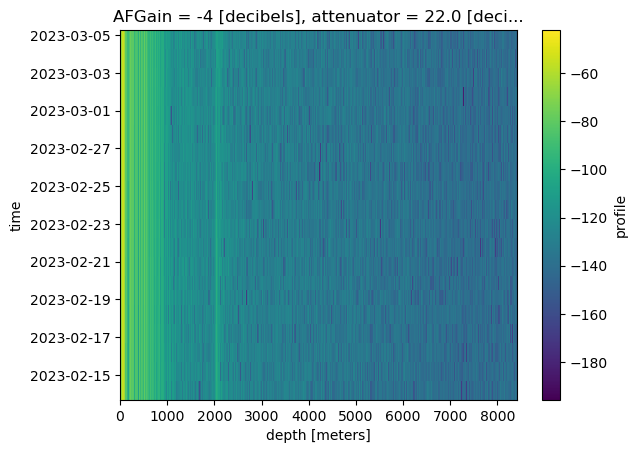

In [20]:
r_reload.chirp.mean(dim='chirp_num').isel(time = slice(30,50)).computeProfile().dB().plot()

## Add profiles
Add profiles to the dataset and compute stacked chirps and profiles. 

In [21]:
full = r_reload.addProfileToDs(max_range = 2500)
profile_stacked = full.profile.mean(dim='chirp_num')
chirp_stacked = full.chirp.mean(dim='chirp_num')
full_stacked = full.assign({'profile_stacked': profile_stacked, 'chirp_stacked': chirp_stacked})

## Write to zarr
Write the final result to a zarr in the google bucket. 

In [22]:
filename = root + '/zarr/full.zarr'
mapper = fsspec.get_mapper(filename, mode='w', token=token)

full_stacked.to_zarr(mapper)

In [23]:
f = load_zarr(mapper)
f

<xarray.Dataset> Size: 18GB
Dimensions:          (attenuator_setting_pair: 1, time: 351, chirp_time: 40001,
                      chirp_num: 100, profile_range: 11889)
Coordinates:
    AFGain           (attenuator_setting_pair) int64 8B dask.array<chunksize=(1,), meta=np.ndarray>
    attenuator       (attenuator_setting_pair) float64 8B dask.array<chunksize=(1,), meta=np.ndarray>
    burst_number     (time) int64 3kB dask.array<chunksize=(351,), meta=np.ndarray>
  * chirp_num        (chirp_num) int64 800B 0 1 2 3 4 5 6 ... 94 95 96 97 98 99
  * chirp_time       (chirp_time) timedelta64[ns] 320kB 00:00:00 ... 00:00:01
    filename         (time) <U90 126kB dask.array<chunksize=(351,), meta=np.ndarray>
    orientation      (time) <U7 10kB dask.array<chunksize=(351,), meta=np.ndarray>
  * profile_range    (profile_range) float64 95kB 0.0 0.2103 ... 2.5e+03 2.5e+03
  * time             (time) datetime64[ns] 3kB 2023-01-16T00:52:00 ... 2023-1...
Dimensions without coordinates: attenuator_setting_pair
Data variables:
    battery_voltage  (time) float64 3kB dask.array<chunksize=(351,), meta=np.ndarray>
    chirp            (time, chirp_time, chirp_num, attenuator_setting_pair) float64 11GB dask.array<chunksize=(22, 40001, 10, 1), meta=np.ndarray>
    chirp_stacked    (time, chirp_time, attenuator_setting_pair) float64 112MB dask.array<chunksize=(22, 40001, 1), meta=np.ndarray>
    latitude         (time) float64 3kB dask.array<chunksize=(351,), meta=np.ndarray>
    longitude        (time) float64 3kB dask.array<chunksize=(351,), meta=np.ndarray>
    profile          (time, chirp_num, attenuator_setting_pair, profile_range) complex128 7GB dask.array<chunksize=(22, 10, 1, 11889), meta=np.ndarray>
    profile_stacked  (time, attenuator_setting_pair, profile_range) complex128 67MB dask.array<chunksize=(22, 1, 11889), meta=np.ndarray>
    temperature_1    (time) float64 3kB dask.array<chunksize=(351,), meta=np.ndarray>
    temperature_2    (time) float64 3kB dask.array<chunksize=(351,), meta=np.ndarray>
Attributes:
    constants:   {'B': 200000000, 'K': 200000000.0, 'c': 300000000.0, 'dt': 2...
    processing:  Created on 2024-10-21 15:30:22.044429

In [24]:
print('everything completed ok and you should find ldeo-glaciology/apres/thwaites/continuous/ApRES_LTG/zarr/full.zarr in the bucket')

everything completed ok and you should find ldeo-glaciology/apres/thwaites/continuous/ApRES_LTG/zarr/full.zarr in the bucket


## locations


In [16]:
LTG_position = gpd.read_file('/Users/jkingslake/Documents/data/thwaites_apres/continuous_csvs/apres_thwaites_continuous_ApRES_LTG_ApRES_LTG.csv')
Lake1_position = gpd.read_file('/Users/jkingslake/Documents/data/thwaites_apres/continuous_csvs/apres_thwaites_continuous_ApRES_Lake1_ApRES_Lake1.csv')
Lake2_position = gpd.read_file('/Users/jkingslake/Documents/data/thwaites_apres/continuous_csvs/apres_thwaites_continuous_ApRES_Lake2_ApRES_Lake2.csv')

In [28]:
# combine the three datasets
import pandas as pd
all_positions = gpd.GeoDataFrame(pd.concat([LTG_position, Lake1_position, Lake2_position], ignore_index=True))
# add cvs


In [30]:
all_positions = gpd.GeoDataFrame(all_positions, geometry=gpd.points_from_xy(all_positions.Longitude, all_positions.Latitude))
all_positions = all_positions.set_crs('EPSG:4326')
all_positions

,Station,Latitude,Longitude,geometry
0,ApRES_LTG,-76.415769,-107.748886,POINT (-107.74889 -76.41577)
1,ApRES_Lake1,-76.474723,-106.933449,POINT (-106.93345 -76.47472)
2,ApRES_Lake2,-76.411538,-107.092143,POINT (-107.09214 -76.41154)


In [31]:
all_positions.to_file('/Users/jkingslake/Documents/data/thwaites_apres/continuous_csvs/apres_thwaites_continuous_all_positions.shp')

In [15]:
full_stacked.profile_stacked.load()

<xarray.DataArray 'profile_stacked' (time: 362, attenuator_setting_pair: 1,
                                     profile_range: 11889)> Size: 69MB
array([[[ 6.68002374e-03+0.00000000e+00j,
          3.64323551e-07+5.88457083e-03j,
         -3.97115910e-03+7.95787624e-07j, ...,
         -3.13873729e-07-3.60635519e-07j,
         -1.23389765e-07-4.16351413e-07j,
          5.59941971e-07-5.69340573e-07j]],

       [[ 6.69701978e-03+0.00000000e+00j,
         -1.19533060e-08+5.89933100e-03j,
         -3.98061215e-03+3.29834417e-07j, ...,
         -6.32162487e-07-3.06725506e-07j,
         -1.07168776e-07-5.24138656e-07j,
          3.87862228e-07-6.00727497e-07j]],

       [[ 6.69241659e-03+0.00000000e+00j,
          6.34100040e-08+5.89531487e-03j,
         -3.97798407e-03+4.19429211e-07j, ...,
         -1.93632186e-07-2.46644366e-07j,
          8.28425792e-08-2.96162017e-07j,
          3.76199746e-07-2.23067560e-07j]],
...
       [[ 6.66799118e-03+0.00000000e+00j,
          3.17788725e-06+5.87527973e-03j,
         -3.96721061e-03+4.26932617e-06j, ...,
          9.53348254e-07-6.71366218e-07j,
          9.29607395e-07+5.62604727e-07j,
         -8.86125569e-08+9.09786342e-07j]],

       [[ 6.66627886e-03+0.00000000e+00j,
          3.20669524e-06+5.87380920e-03j,
         -3.96624618e-03+4.25959342e-06j, ...,
          9.02973802e-07-3.31087780e-07j,
          4.74961702e-07+7.07892626e-07j,
         -3.94728744e-07+4.56977899e-07j]],

       [[ 6.66697204e-03+0.00000000e+00j,
          3.21395190e-06+5.87440511e-03j,
         -3.96663790e-03+4.31102171e-06j, ...,
          1.24010024e-06+1.00643497e-07j,
          7.87174834e-08+9.72338634e-07j,
         -5.74623030e-07+3.02553256e-07j]]])
Coordinates:
    AFGain         (attenuator_setting_pair) int64 8B -14
    attenuator     (attenuator_setting_pair) float64 8B 6.0
    burst_number   (time) int64 3kB 0 1 0 1 0 1 0 1 0 1 ... 1 0 1 0 1 0 1 0 1 0
    filename       (time) <U92 133kB 'gs://ldeo-glaciology/apres/thwaites/con...
    orientation    (time) <U7 10kB 'unknown' 'unknown' ... 'unknown' 'unknown'
  * time           (time) datetime64[ns] 3kB 2023-01-16T04:22:59 ... 2024-01-...
  * profile_range  (profile_range) float64 95kB 0.0 0.2103 ... 2.5e+03 2.5e+03
Dimensions without coordinates: attenuator_setting_pair

In [17]:
full_stacked.profile_stacked.nbytes/1e6

69.812208

In [18]:
dB = full_stacked.profile_stacked.isel(time=slice(5,-1)).dB().load()

KeyboardInterrupt: 

In [19]:
dB

<xarray.DataArray 'profile_stacked' (time: 356, attenuator_setting_pair: 1,
                                     profile_range: 11889)> Size: 34MB
array([[[ -43.47478601,  -44.57611776,  -47.99258849, ...,
         -134.26285621, -128.01299281, -122.21411856]],

       [[ -43.47912211,  -44.580411  ,  -47.99670598, ...,
         -126.68280657, -126.50316807, -128.39706169]],

       [[ -43.48366422,  -44.58493209,  -48.00117005, ...,
         -122.41687615, -121.92955264, -122.60269614]],

       ...,

       [[ -43.51903353,  -44.61830927,  -48.02907053, ...,
         -120.1790747 , -124.94936918, -133.7758992 ]],

       [[ -43.52009967,  -44.61942775,  -48.03028984, ...,
         -118.6658709 , -119.27862648, -120.78020606]],

       [[ -43.52233047,  -44.621602  ,  -48.03240165, ...,
         -120.33867279, -121.38644488, -124.3813619 ]]])
Coordinates:
    AFGain         (attenuator_setting_pair) int64 8B -14
    attenuator     (attenuator_setting_pair) float64 8B 6.0
    burst_number   (time) int64 3kB 1 0 1 0 1 0 1 0 1 0 ... 0 1 0 1 0 1 0 1 0 1
    filename       (time) <U92 131kB 'gs://ldeo-glaciology/apres/thwaites/con...
    orientation    (time) <U7 10kB 'unknown' 'unknown' ... 'unknown' 'unknown'
  * time           (time) datetime64[ns] 3kB 2023-01-21T04:22:47 ... 2024-01-...
  * profile_range  (profile_range) float64 95kB 0.0 0.2103 ... 2.5e+03 2.5e+03
Dimensions without coordinates: attenuator_setting_pair

## Reloading saved zarrs
I downloaded the zarrs I produced in the google bucket (ApRES_Lake1, ApRES_Lake2 and ApRES_Lake1) to local storage for archiving. 


In [ ]:
f = '/Users/jkingslake/Documents/data/thwaites_apres/original/continuous/ApRES_Lake1/zarr/rechunked.zarr'
ds = xr.open_dataset(f, engine = 'zarr', chunks = {})
ds

/var/folders/kl/3mt9f4qs1559xwy3mr60s7980000gp/T/ipykernel_9687/4057637819.py:3: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds = xr.open_dataset(f, engine = 'zarr', chunks = {})


<xarray.Dataset> Size: 19GB
Dimensions:          (attenuator_setting_pair: 1, time: 362, chirp_time: 40001,
                      chirp_num: 100, profile_range: 11889)
Coordinates:
    AFGain           (attenuator_setting_pair) int64 8B dask.array<chunksize=(1,), meta=np.ndarray>
    attenuator       (attenuator_setting_pair) float64 8B dask.array<chunksize=(1,), meta=np.ndarray>
    burst_number     (time) int64 3kB dask.array<chunksize=(362,), meta=np.ndarray>
  * chirp_num        (chirp_num) int64 800B 0 1 2 3 4 5 6 ... 94 95 96 97 98 99
  * chirp_time       (chirp_time) timedelta64[ns] 320kB 00:00:00 ... 00:00:01
    filename         (time) <U92 133kB dask.array<chunksize=(362,), meta=np.ndarray>
    orientation      (time) <U7 10kB dask.array<chunksize=(362,), meta=np.ndarray>
  * profile_range    (profile_range) float64 95kB 0.0 0.2103 ... 2.5e+03 2.5e+03
  * time             (time) datetime64[ns] 3kB 2023-01-16T04:22:59 ... 2024-0...
Dimensions without coordinates: attenuator_setting_pair
Data variables:
    battery_voltage  (time) float64 3kB dask.array<chunksize=(362,), meta=np.ndarray>
    chirp            (time, chirp_time, chirp_num, attenuator_setting_pair) float64 12GB dask.array<chunksize=(23, 40001, 10, 1), meta=np.ndarray>
    chirp_stacked    (time, chirp_time, attenuator_setting_pair) float64 116MB dask.array<chunksize=(23, 40001, 1), meta=np.ndarray>
    latitude         (time) float64 3kB dask.array<chunksize=(362,), meta=np.ndarray>
    longitude        (time) float64 3kB dask.array<chunksize=(362,), meta=np.ndarray>
    profile          (time, chirp_num, attenuator_setting_pair, profile_range) complex128 7GB dask.array<chunksize=(23, 10, 1, 11889), meta=np.ndarray>
    profile_stacked  (time, attenuator_setting_pair, profile_range) complex128 69MB dask.array<chunksize=(23, 1, 11889), meta=np.ndarray>
    temperature_1    (time) float64 3kB dask.array<chunksize=(362,), meta=np.ndarray>
    temperature_2    (time) float64 3kB dask.array<chunksize=(362,), meta=np.ndarray>
Attributes:
    constants:   {'B': 200000000, 'K': 200000000.0, 'c': 300000000.0, 'dt': 2...
    processing:  Created on 2024-10-17 10:38:11.086220

In [56]:
f = '/Users/jkingslake/Documents/data/thwaites_apres/original/continuous/ApRES_Lake1/zarr/rechunked.zarr'
ds = xr.open_dataset(f, engine = 'zarr', chunks = None).load()
ds

/var/folders/kl/3mt9f4qs1559xwy3mr60s7980000gp/T/ipykernel_9687/432631749.py:2: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds = xr.open_dataset(f, engine = 'zarr', chunks = None).load()


<xarray.Dataset> Size: 12GB
Dimensions:          (attenuator_setting_pair: 1, time: 362, chirp_time: 40001,
                      chirp_num: 100)
Coordinates:
    AFGain           (attenuator_setting_pair) int64 8B -14
    attenuator       (attenuator_setting_pair) float64 8B 6.0
    burst_number     (time) int64 3kB 0 1 0 1 0 1 0 1 0 1 ... 0 1 0 1 0 1 0 1 0
  * chirp_num        (chirp_num) int64 800B 0 1 2 3 4 5 6 ... 94 95 96 97 98 99
  * chirp_time       (chirp_time) timedelta64[ns] 320kB 00:00:00 ... 00:00:01
    filename         (time) <U92 133kB 'gs://ldeo-glaciology/apres/thwaites/c...
    orientation      (time) <U7 10kB 'unknown' 'unknown' ... 'unknown' 'unknown'
  * time             (time) datetime64[ns] 3kB 2023-01-16T04:22:59 ... 2024-0...
Dimensions without coordinates: attenuator_setting_pair
Data variables:
    battery_voltage  (time) float64 3kB 14.49 14.19 14.16 ... 14.15 14.15 14.14
    chirp            (time, chirp_time, chirp_num, attenuator_setting_pair) float64 12GB ...
    latitude         (time) float64 3kB -76.49 -76.49 -76.49 ... -76.49 -76.49
    longitude        (time) float64 3kB -107.0 -107.0 -107.0 ... -107.0 -107.0
    temperature_1    (time) float64 3kB -6.008 -10.91 -16.8 ... -13.27 -13.66
    temperature_2    (time) float64 3kB -9.203 -16.66 -14.5 ... -15.48 -13.52
Attributes:
    constants:   {'B': 200000000, 'K': 200000000.0, 'c': 300000000.0, 'dt': 2...
    processing:  Created on 2024-10-17 10:38:11.086220

In [54]:
import numpy as np

In [57]:
ds = ds.assign_coords(chirp_time=(ds.chirp_time / np.timedelta64(1, 's')))
ds
#ds.chirp.isel(time=slice(0,10),chirp_num=0).squeeze()#.plot()

<xarray.Dataset> Size: 12GB
Dimensions:          (attenuator_setting_pair: 1, time: 362, chirp_time: 40001,
                      chirp_num: 100)
Coordinates:
    AFGain           (attenuator_setting_pair) int64 8B -14
    attenuator       (attenuator_setting_pair) float64 8B 6.0
    burst_number     (time) int64 3kB 0 1 0 1 0 1 0 1 0 1 ... 0 1 0 1 0 1 0 1 0
  * chirp_num        (chirp_num) int64 800B 0 1 2 3 4 5 6 ... 94 95 96 97 98 99
    filename         (time) <U92 133kB 'gs://ldeo-glaciology/apres/thwaites/c...
    orientation      (time) <U7 10kB 'unknown' 'unknown' ... 'unknown' 'unknown'
  * time             (time) datetime64[ns] 3kB 2023-01-16T04:22:59 ... 2024-0...
  * chirp_time       (chirp_time) float64 320kB 0.0 2.5e-05 5e-05 ... 1.0 1.0
Dimensions without coordinates: attenuator_setting_pair
Data variables:
    battery_voltage  (time) float64 3kB 14.49 14.19 14.16 ... 14.15 14.15 14.14
    chirp            (time, chirp_time, chirp_num, attenuator_setting_pair) float64 12GB ...
    latitude         (time) float64 3kB -76.49 -76.49 -76.49 ... -76.49 -76.49
    longitude        (time) float64 3kB -107.0 -107.0 -107.0 ... -107.0 -107.0
    temperature_1    (time) float64 3kB -6.008 -10.91 -16.8 ... -13.27 -13.66
    temperature_2    (time) float64 3kB -9.203 -16.66 -14.5 ... -15.48 -13.52
Attributes:
    constants:   {'B': 200000000, 'K': 200000000.0, 'c': 300000000.0, 'dt': 2...
    processing:  Created on 2024-10-17 10:38:11.086220

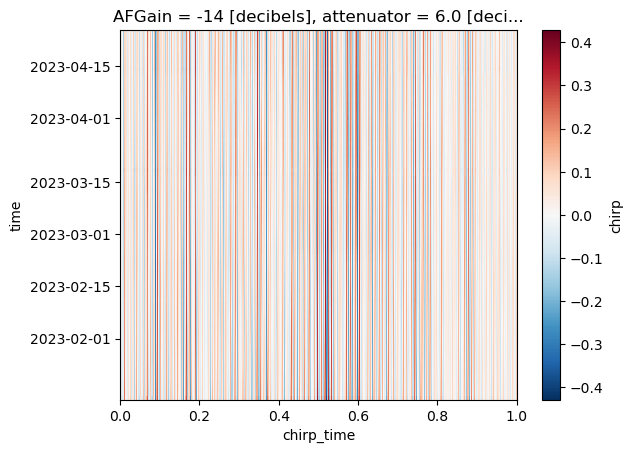

In [61]:
ds.chirp.isel(time=slice(0,100)).mean(dim='chirp_num').squeeze().plot()

In [ ]:
def remove_constants_attr(ds):
    for c in ds.attrs['constants']:
        ds.attrs[c] = ds.attrs['constants'][c]
    del ds.attrs['constants']
    return ds
ds = remove_constants_attr(ds)
ds

<xarray.Dataset> Size: 12GB
Dimensions:          (attenuator_setting_pair: 1, time: 362, chirp_time: 40001,
                      chirp_num: 100)
Coordinates:
    AFGain           (attenuator_setting_pair) int64 8B -14
    attenuator       (attenuator_setting_pair) float64 8B 6.0
    burst_number     (time) int64 3kB 0 1 0 1 0 1 0 1 0 1 ... 0 1 0 1 0 1 0 1 0
  * chirp_num        (chirp_num) int64 800B 0 1 2 3 4 5 6 ... 94 95 96 97 98 99
  * chirp_time       (chirp_time) timedelta64[ns] 320kB 00:00:00 ... 00:00:01
    filename         (time) <U92 133kB 'gs://ldeo-glaciology/apres/thwaites/c...
    orientation      (time) <U7 10kB 'unknown' 'unknown' ... 'unknown' 'unknown'
  * time             (time) datetime64[ns] 3kB 2023-01-16T04:22:59 ... 2024-0...
Dimensions without coordinates: attenuator_setting_pair
Data variables:
    battery_voltage  (time) float64 3kB 14.49 14.19 14.16 ... 14.15 14.15 14.14
    chirp            (time, chirp_time, chirp_num, attenuator_setting_pair) float64 12GB ...
    latitude         (time) float64 3kB -76.49 -76.49 -76.49 ... -76.49 -76.49
    longitude        (time) float64 3kB -107.0 -107.0 -107.0 ... -107.0 -107.0
    temperature_1    (time) float64 3kB -6.008 -10.91 -16.8 ... -13.27 -13.66
    temperature_2    (time) float64 3kB -9.203 -16.66 -14.5 ... -15.48 -13.52
Attributes:
    processing:  Created on 2024-10-17 10:38:11.086220
    B:           200000000
    K:           200000000.0
    c:           300000000.0
    dt:          2.5e-05
    ep:          3.18
    f_1:         200000000
    f_2:         400000000
    f_c:         300000000.0

In [36]:
archived_data_path = '../../../../../../data/thwaites_apres/archiving'
ds.to_netcdf('full.nc')


In [38]:
ds  = xr.open_dataset('full.nc').load()

/var/folders/kl/3mt9f4qs1559xwy3mr60s7980000gp/T/ipykernel_9687/2787952468.py:1: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  ds  = xr.open_dataset('full.nc').load()


In [43]:
ds.chirp.isel(time=slice(0,10)).mean(dim='chirp_num')

<xarray.DataArray 'chirp' (time: 10, chirp_time: 40001,
                           attenuator_setting_pair: 1)> Size: 3MB
array([[[ 1.50901794e-02],
        [ 9.34600830e-05],
        [-5.60443878e-02],
        ...,
        [ 8.26496124e-02],
        [ 8.93924713e-02],
        [ 3.26590729e-01]],

       [[ 1.56391144e-02],
        [ 2.16522217e-03],
        [-4.62932587e-02],
        ...,
        [ 8.29246521e-02],
        [ 8.04428101e-02],
        [-1.28870773e-01]],

       [[ 1.60129547e-02],
        [ 3.08456421e-03],
        [-4.64847565e-02],
        ...,
...
        ...,
        [ 9.01123047e-02],
        [ 8.66405487e-02],
        [-1.70432281e-01]],

       [[ 1.87583923e-02],
        [ 7.60498047e-03],
        [-3.20667267e-02],
        ...,
        [ 9.12757874e-02],
        [ 8.77098083e-02],
        [-1.68270874e-01]],

       [[ 1.51645660e-02],
        [ 4.05654907e-03],
        [-3.59428406e-02],
        ...,
        [ 9.15973663e-02],
        [ 8.81950378e-02],
        [-1.63082504e-01]]], shape=(10, 40001, 1))
Coordinates:
    AFGain        (attenuator_setting_pair) int64 8B -14
    attenuator    (attenuator_setting_pair) float64 8B 6.0
    burst_number  (time) int64 80B 0 1 0 1 0 1 0 1 0 1
  * chirp_time    (chirp_time) timedelta64[ns] 320kB 00:00:00 ... 00:00:01
    filename      (time) <U92 4kB 'gs://ldeo-glaciology/apres/thwaites/contin...
    orientation   (time) <U7 280B 'unknown' 'unknown' ... 'unknown' 'unknown'
  * time          (time) datetime64[ns] 80B 2023-01-16T04:22:59 ... 2023-01-2...
Dimensions without coordinates: attenuator_setting_pair

In [ ]:
def remove_constants_attr(ds):
    for c in ds.attrs['constants']:
        ds.attrs[c] = ds.attrs['constants'][c]
    del ds.attrs['constants']
    return ds

K
c
dt
ep
f_1
f_2
f_c


In [24]:
ds

<xarray.Dataset> Size: 12GB
Dimensions:          (attenuator_setting_pair: 1, time: 362, chirp_time: 40001,
                      chirp_num: 100)
Coordinates:
    AFGain           (attenuator_setting_pair) int64 8B dask.array<chunksize=(1,), meta=np.ndarray>
    attenuator       (attenuator_setting_pair) float64 8B dask.array<chunksize=(1,), meta=np.ndarray>
    burst_number     (time) int64 3kB dask.array<chunksize=(362,), meta=np.ndarray>
  * chirp_num        (chirp_num) int64 800B 0 1 2 3 4 5 6 ... 94 95 96 97 98 99
  * chirp_time       (chirp_time) timedelta64[ns] 320kB 00:00:00 ... 00:00:01
    filename         (time) <U92 133kB dask.array<chunksize=(362,), meta=np.ndarray>
    orientation      (time) <U7 10kB dask.array<chunksize=(362,), meta=np.ndarray>
  * time             (time) datetime64[ns] 3kB 2023-01-16T04:22:59 ... 2024-0...
Dimensions without coordinates: attenuator_setting_pair
Data variables:
    battery_voltage  (time) float64 3kB dask.array<chunksize=(362,), meta=np.ndarray>
    chirp            (time, chirp_time, chirp_num, attenuator_setting_pair) float64 12GB dask.array<chunksize=(23, 40001, 10, 1), meta=np.ndarray>
    latitude         (time) float64 3kB dask.array<chunksize=(362,), meta=np.ndarray>
    longitude        (time) float64 3kB dask.array<chunksize=(362,), meta=np.ndarray>
    temperature_1    (time) float64 3kB dask.array<chunksize=(362,), meta=np.ndarray>
    temperature_2    (time) float64 3kB dask.array<chunksize=(362,), meta=np.ndarray>
Attributes:
    processing:  Created on 2024-10-17 10:38:11.086220
    B:           200000000
    K:           200000000.0
    c:           300000000.0
    dt:          2.5e-05
    ep:          3.18
    f_1:         200000000
    f_2:         400000000
    f_c:         300000000.0

In [30]:
site_for_reload = 'ApRES_Lake1'
filename_for_reload = f"gs://ldeo-glaciology/apres/thwaites/continuous/{site_for_reload}/zarr/full.zarr"
mapper = fsspec.get_mapper(filename_for_reload, mode='w', token=token)
r_lake1 = load_zarr(mapper)

site_for_reload = 'ApRES_LTG'
filename_for_reload = f"gs://ldeo-glaciology/apres/thwaites/continuous/{site_for_reload}/zarr/full_2"
mapper = fsspec.get_mapper(filename_for_reload, mode='w', token=token)
r_LTG = load_zarr(mapper)

In [33]:
r_lake1.dims

FrozenMappingWarningOnValuesAccess({'attenuator_setting_pair': 1, 'time': 362, 'chirp_time': 40001, 'chirp_num': 100, 'profile_range': 11889})

In [34]:
r_LTG.dims

FrozenMappingWarningOnValuesAccess({'attenuator_setting_pair': 1, 'time': 355, 'chirp_time': 40001, 'chirp_num': 100, 'profile_range': 11889})

/tmp/ipykernel_6182/1634667285.py:4: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


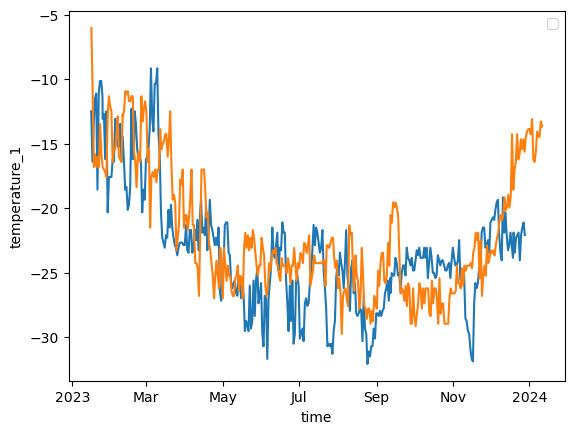

In [42]:
import matplotlib.pyplot as plt
r_LTG.isel(time=slice(4,-1)).temperature_1.plot()
r_lake1.temperature_1.plot()
plt.legend()
